In [1]:
import log_reg
from imp import reload

import numpy as np
import pandas as pd

import evaluation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

%pylab --no-import-all inline
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
Y = 10
vocab_min = 3

In [3]:
reload(log_reg)
notefile = '../mimicdata/notes_' + str(Y) + '_train_ind.csv'
X_tr = log_reg.construct_csr_matrix(notefile)

Processing...............................................................

In [4]:
X_tr.shape

(15492, 40000)

In [5]:
reload(log_reg)
labelfile = '../mimicdata/labels_10_train.csv'
yy_tr = log_reg.construct_label_lists(labelfile, Y, X_tr.shape[0])

In [6]:
X_tr[0].toarray().sum()

4862

In [7]:
devfile = '../mimicdata/notes_' + str(Y) + '_dev_ind.csv'
X_dv = log_reg.construct_csr_matrix(devfile)

Processing.................................

In [8]:
X_dv.shape

(7746, 40000)

In [9]:
labelfile_dev = '../mimicdata/labels_10_dev.csv'
yy_dev = log_reg.construct_label_lists(labelfile_dev, Y, X_dv.shape[0])

In [10]:
yy_dev[-1]

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
def plot_metrics(ax, start, end, steps, y):
    x = np.linspace(start, end, steps)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        ax.plot(x, y)
    fig.canvas.draw()

## LogReg

***** C = 0.01 *****
5 iterations: 
acc,precision,recall,f1
0.300047899786 0.552300009426 0.387105275022 0.395562323446
10 iterations: 
acc,precision,recall,f1
0.330528403805 0.567270255206 0.431449411678 0.43320430523
15 iterations: 
acc,precision,recall,f1
0.342700431149 0.56812020746 0.454434700552 0.448047628129
20 iterations: 
acc,precision,recall,f1
0.35061070947 0.568530813651 0.470245830926 0.457964250062
25 iterations: 
acc,precision,recall,f1
0.355559602703 0.570064221575 0.480512625052 0.464461188588
30 iterations: 
acc,precision,recall,f1
0.360702093041 0.572400091804 0.489024903791 0.470491058504
35 iterations: 
acc,precision,recall,f1
0.364104873381 0.574424587806 0.495313761532 0.474655227432
40 iterations: 
acc,precision,recall,f1
0.365839409178 0.574088981922 0.499677304005 0.476969078913
45 iterations: 
acc,precision,recall,f1
0.368393415547 0.575148156345 0.504670459715 0.480194276397
50 iterations: 
acc,precision,recall,f1
0.370846857979 0.57625061988 0.508401315169

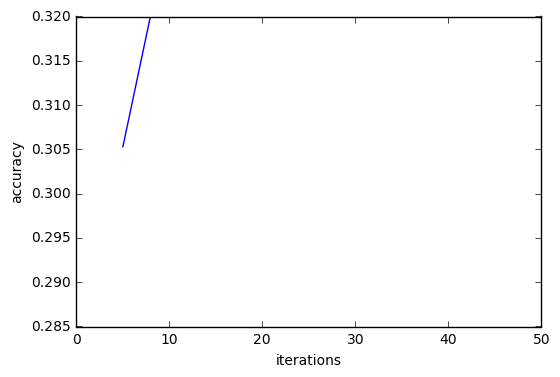

In [99]:
#optimize hyperparams of LR
reload(evaluation)
iter_step = 5
num_steps = 10
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
accs = {C:[] for C in Cs}
precisions = {C:[] for C in Cs}
recalls = {C:[] for C in Cs}
f1s = {C:[] for C in Cs}

fig,ax = plt.subplots(1,1)
ax.set_xlabel("iterations")
ax.set_ylabel("accuracy")
ax.set_xlim(0,iter_step*num_steps)

for C in Cs:
    print("***** C = " + str(C) + " *****")
    for i in range(num_steps):
        print(str((i+1)*iter_step) + " iterations: ")
        reg = OneVsRestClassifier(LogisticRegression(C=C,solver='sag', max_iter=iter_step*(i+1)))
        reg.fit(X_tr, yy_tr)
        yhat = reg.predict(X_dv)
        acc,precision,recall,f1 = evaluation.all_metrics(yhat, yy_dev)
        
        print("acc,precision,recall,f1")
        print(acc,precision,recall,f1)
        
        accs[C].append(acc)
        precisions[C].append(precision)
        recalls[C].append(recall)
        f1s[C].append(f1)
        
        plot_metrics(ax, iter_step, (i+1)*iter_step, i+1, accs[C])

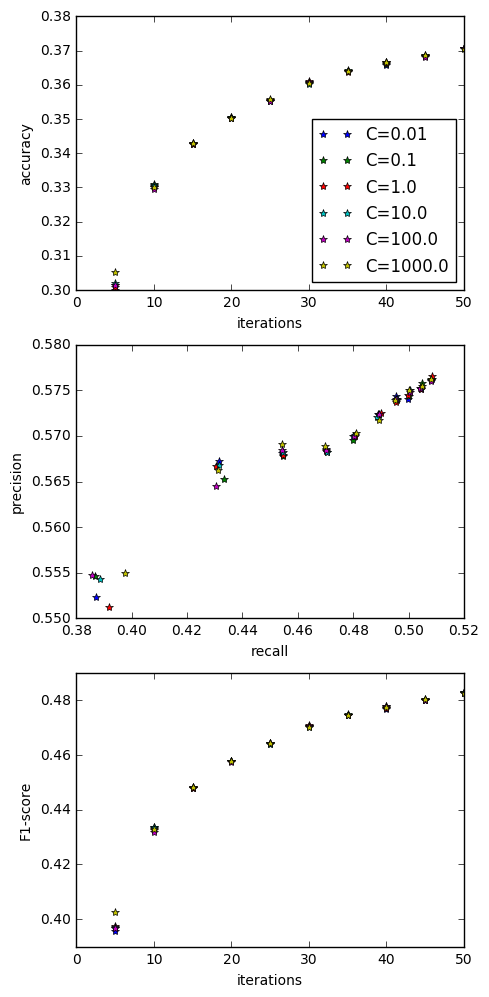

In [136]:
its = np.linspace(5,50,10)

fig,ax = plt.subplots(3,1)
fig.set_size_inches(5,12)
ax[0].set_xlabel("iterations")
ax[1].set_xlabel("recall")
ax[2].set_xlabel("iterations")
ax[0].set_ylabel("accuracy")
ax[1].set_ylabel("precision")
ax[2].set_ylabel("F1-score")
ax[0].set_xlim(0,iter_step*num_steps)
# ax[1].set_xlim(0,1)
ax[2].set_xlim(0,iter_step*num_steps)

for C in Cs:
    ax[0].plot(its,accs[C], '*', label="C=" + str(C))
    ax[1].plot(recalls[C], precisions[C], '*', label="C=" + str(C))
    ax[2].plot(its, f1s[C], '*', label="C=" + str(C))
ax[0].legend(loc=4)

In [140]:
mean_accs = [np.array(accs[C]).mean() for C in Cs]
mean_accs

[0.35093336960397348,
 0.3511319923442307,
 0.35104055754326852,
 0.35119138807945915,
 0.35099443030504202,
 0.35149700920905386]

In [151]:
mean_f1s = [np.array(f1s[C]).mean() for C in Cs]
np.array(f1s[1000]).mean()

0.45920534988256778

In [ ]:
#optimize hyperparams of LR
reload(evaluation)
iter_step = 10
num_steps = 50
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
accs = {C:[] for C in Cs}
precisions = {C:[] for C in Cs}
recalls = {C:[] for C in Cs}
f1s = {C:[] for C in Cs}

fig,ax = plt.subplots(1,1)
ax.set_xlabel("iterations")
ax.set_ylabel("accuracy")
ax.set_xlim(0,iter_step*num_steps)

for C in Cs:
    print("***** C = " + str(C) + " *****")
    for i in range(num_steps):
        print(str((i+1)*iter_step) + " iterations: ")
        reg = OneVsRestClassifier(LogisticRegression(C=C,solver='sag', max_iter=iter_step*(i+1)))
        reg.fit(X_tr, yy_tr)
        yhat = reg.predict(X_dv)
        acc,precision,recall,f1 = evaluation.all_metrics(yhat, yy_dev)
        
        print("acc,precision,recall,f1")
        print(acc,precision,recall,f1)
        
        accs[C].append(acc)
        precisions[C].append(precision)
        recalls[C].append(recall)
        f1s[C].append(f1)
        
#         plot_metrics(ax, iter_step, (i+1)*iter_step, i+1, accs[C])

***** C = 0.01 *****
10 iterations: 
acc,precision,recall,f1
0.330089006512 0.565409540613 0.43115822196 0.432490865128
20 iterations: 


In [12]:
#run for a long time
lr_long = OneVsRestClassifier(LogisticRegression(C=1000.0, solver='sag', max_iter=500))
lr_long.fit(X_tr, yy_tr)
yhat = lr_long.predict(X_dv)
acc, precision, recall, f1 = evaluation.all_metrics(yhat, yy_dev)

print("acc,precision,recall,f1")
print(acc,precision,recall,f1)

acc,precision,recall,f1
0.399668748642 0.565632748495 0.584710541846 0.517098567836


## SVM

In [32]:
from sklearn.svm import SVC
iters = [3, 5, 7, 10]
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
svms = []
for mx_iter in iters:
    for C in Cs:
        print("C = " + str(C) + ", iters = " + str(mx_iter) + ": ")
        svm = OneVsRestClassifier(SVC(C=C, max_iter=mx_iter))
        svm.fit(X_tr, yy_tr)
        yhat = svm.predict(X_dv)
        acc,precision,recall,f1 = evaluation.all_metrics(yhat, yy_dev)
        print("acc,precision,recall,f1")
        print(acc,precision,recall,f1)
        svms.append(svm)

C = 0.01, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 0.1, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 1.0, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 10.0, iters = 3: 
acc,precision,recall,f1
0.206748285854 0.25461677097 0.589105693056 0.310577218286
C = 100.0, iters = 3: 
acc,precision,recall,f1
0.0880359140816 0.112800923364 0.242436137033 0.13221510305
C = 1000.0, iters = 3: 
acc,precision,recall,f1
0.122095172521 0.189635203423 0.24662826487 0.181343287494
C = 0.01, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 0.1, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 1.0, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 10.0, iters = 5: 
acc,precision,recall,f1
0.2034

KeyboardInterrupt: 

In [18]:
pcts = sorted([np.array(yy_dev[i]).mean() for i in range(Y)])
pcts
#these are the % of instances containing this label for each of the top 10 labels

[0.18409501678285567,
 0.18874257681383941,
 0.2101729925122644,
 0.24141492383165505,
 0.26452362509682414,
 0.2747224373870385,
 0.3187451587916344,
 0.31900335657113349,
 0.32726568551510454,
 0.55499612703330747]

In [20]:
accs = [(yhat_tr == yy[i]).mean() for i in range(Y)]
accs

[0.77956364575264647,
 0.65085205267234703,
 0.45339530080041313,
 0.63665117479989675,
 0.77285050348566997,
 0.88187451587916343,
 0.81493674154402274,
 0.67867286341337463,
 0.86586625355021951,
 0.78563129357087524]